In [1]:
from collections import defaultdict

In [2]:
from os.path import join, dirname, exists
from os import makedirs
from itertools import chain, islice

from thesis_v2 import dir_dict

In [3]:
from scipy.stats import sem
import numpy as np

In [4]:
import pandas as pd

In [5]:
f_main_result = join(dir_dict['analyses'], 'tang_refactored', '20200819+20200914', 'hal_tuning_complete_ignore_seed_in_baseline.pkl')
df_main_result = pd.read_pickle(f_main_result)
# remove cls>7 results
df_main_result = df_main_result[df_main_result.index.get_level_values('rcnn_bl_cls')<=7].sort_index()

In [6]:
df_main_result

hal_tuning_analysis  \
act_fn   ff_1st_bn_before_act loss_type model_seed num_layer out_channel rcnn_bl_cls readout_type train_keep                       
relu     False                mse       0          2         8           1           cm-avg       350                       None   
                                                                                                  700                       None   
                                                                                                  1400                      None   
                                                                                     cm-last      350                       None   
                                                                                                  700                       None   
...                                                                                                                          ...   
softplus True                 poisson   1          6         16          1           legacy       700                       None   
                                                                                                  1400                      None   
                                                             32          1           legacy       350                       None   
                                                                                                  700                       None   
                                                                                                  1400                      None   

                                                                                                             hal_tuning_analysis_half_improved  \
act_fn   ff_1st_bn_before_act loss_type model_seed num_layer out_channel rcnn_bl_cls readout_type train_keep                                     
relu     False                mse       0          2         8           1           cm-avg       350                                     None   
                                                                                                  700                                     None   
                                                                                                  1400                                    None   
                                                                                     cm-last      350                                     None   
                                                                                                  700                                     None   
...                                                                                                                                        ...   
softplus True                 poisson   1          6         16          1           legacy       700                                     None   
                                                                                                  1400                                    None   
                                                             32          1           legacy       350                                     None   
                                                                                                  700                                     None   
                                                                                                  1400                                    None   

                                                                                                             hal_tuning_analysis_half_improved_baseline  \
act_fn   ff_1st_bn_before_act loss_type model_seed num_layer out_channel rcnn_bl_cls readout_type train_keep                                              
relu     False                mse       0          2         8           1           cm-avg       350                                              None   
                            

In [7]:
def get_mean(x):
    if x is None:
        return np.nan
    return x['diffs'].mean()
def get_sem(x):
    if x is None:
        return np.nan
    return sem(x['diffs'], ddof=0)


df_main_result['hal_tuning_improved_mean'] = df_main_result['hal_tuning_analysis_improved'].map(lambda x: get_mean(x))
df_main_result['hal_tuning_improved_baseline_mean'] = df_main_result['hal_tuning_analysis_improved_baseline'].map(lambda x: get_mean(x))
df_main_result['hal_tuning_half_improved_mean'] = df_main_result['hal_tuning_analysis_half_improved'].map(lambda x: get_mean(x))
df_main_result['hal_tuning_half_improved_baseline_mean'] = df_main_result['hal_tuning_analysis_half_improved_baseline'].map(lambda x: get_mean(x))

In [8]:
# show mean vs sem, for different cls

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

In [10]:
def final_one_case(
    *,
    data_baseline,
    data_learned,
    save_name=None):
    # plot a final one
    plt.close('all')
    
    data_baseline_all = []
    data_learned_all = []
    
    assert data_baseline.keys() == data_learned.keys()
    for z1, z2 in zip(data_baseline.values(), data_learned.values()):
        data_baseline_all.extend(z1)
        data_learned_all.extend(z2)
    assert len(data_baseline) == len(data_learned) == 4
    
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 20), squeeze=False)
    data_all = np.asarray([data_baseline_all, data_learned_all]).T
    print(data_all.shape)
    axes[0,0].hist(data_all, label=['baseline', 'learned'], bins=20)
    axes[0,0].legend()
    axes[0,0].set_title('overall')
    
    axes[0,1].scatter(data_baseline_all, data_learned_all, s=8)
    axes[0,1].set_xlabel('baseline')
    axes[0,1].set_ylabel('learned')
    axes[0,1].plot([-0.2, 0.2], [-0.2, 0.2], linestyle='--')
    
    
    # for following rows
    for axes_this, (x1, y1), (x2, y2) in zip(axes[1:], data_baseline.items(), data_learned.items()):
        assert x1 == x2
        axes_this[0].set_title(x1)
        axes_this[0].hist(np.asarray([y1, y2]).T, label=['baseline', 'learned'], bins=20)
        axes_this[0].legend()
        
        axes_this[1].scatter(y1, y2, s=8)
        axes_this[1].set_xlabel('baseline')
        axes_this[1].set_ylabel('learned')
        axes_this[1].plot([-0.2, 0.2], [-0.2, 0.2], linestyle='--')
    
    plt.show()

(6912, 2)


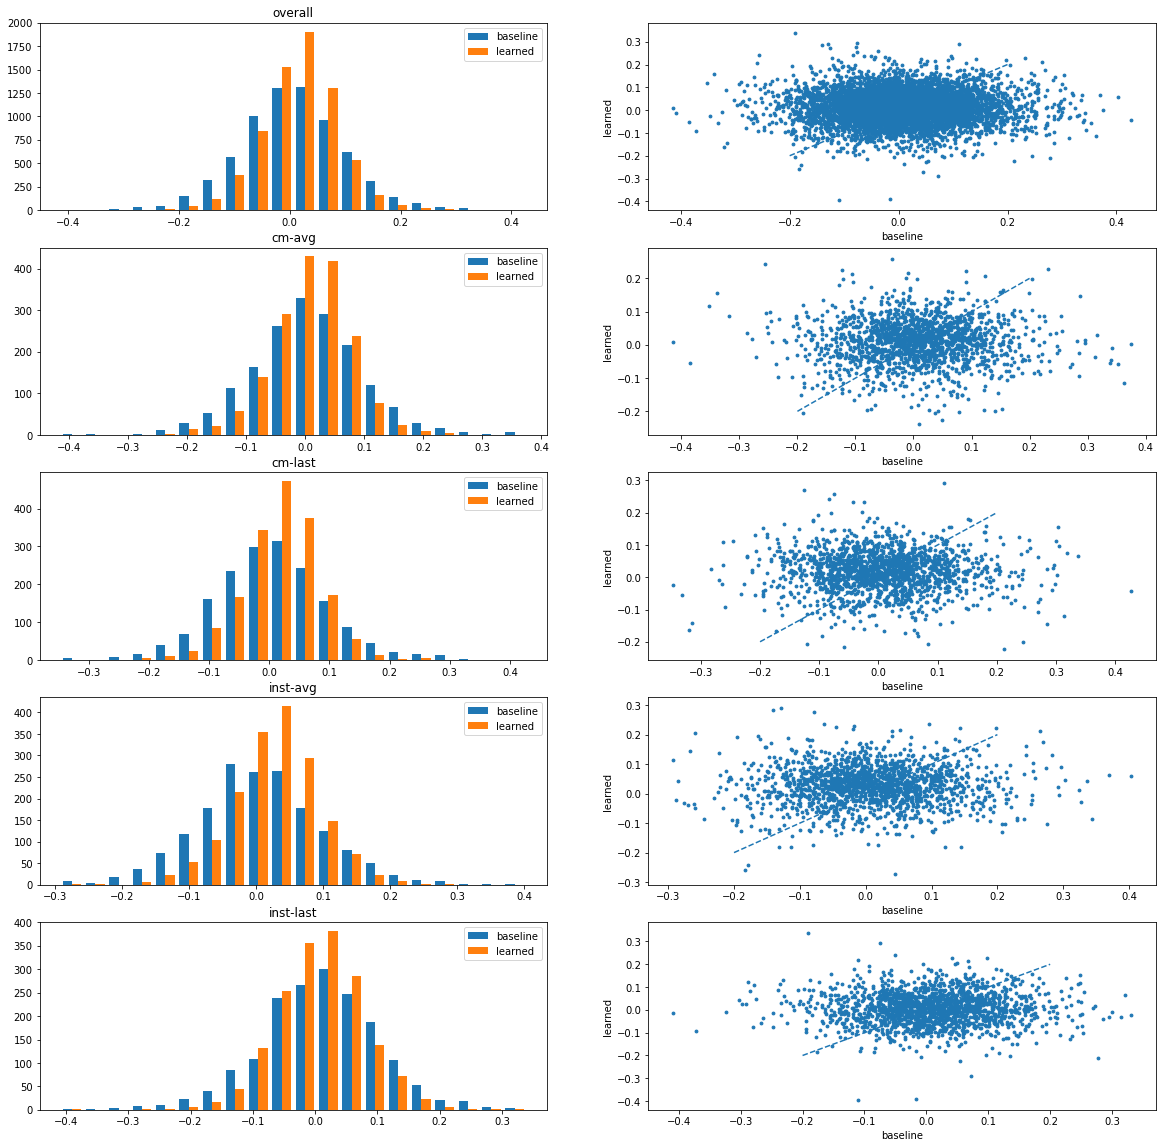

(6912, 2)


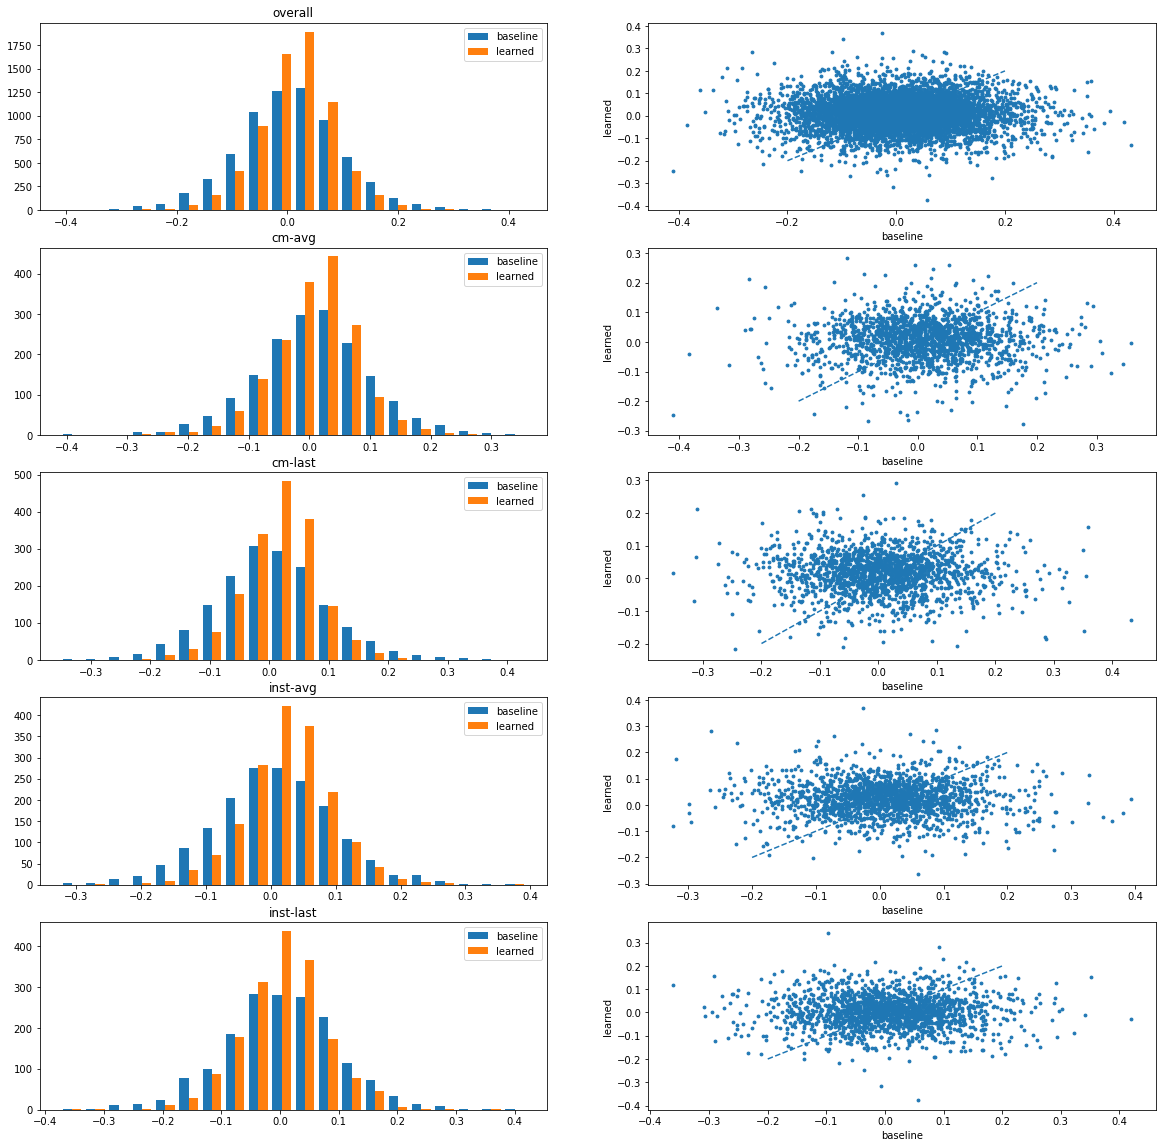

In [11]:
def show_scatter_plots():
    diff_mean_half_improved_all = defaultdict(list)
    diff_mean_half_improved_all_baseline = defaultdict(list)
    diff_mean_improved_all = defaultdict(list)
    diff_mean_improved_all_baseline = defaultdict(list)
    for train_keep in df_main_result.index.get_level_values('train_keep').unique():
        df_main_result_this_train = df_main_result.xs(train_keep, level='train_keep')
        for cls in df_main_result_this_train.index.get_level_values('rcnn_bl_cls').unique():
            if cls == 1:
                continue

            df_this_main = df_main_result_this_train.xs(cls, level='rcnn_bl_cls')

            for readout_type in df_this_main.index.get_level_values('readout_type').unique():
                df_this_readout = df_this_main.xs(readout_type, level='readout_type')
#                 plt.close('all')
#                 fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
#                 axes = axes.ravel()

#                 axes[0].scatter(
#                     df_this_readout['hal_tuning_improved_baseline_mean'].values,
#                     df_this_readout['hal_tuning_improved_mean'].values,
#                     alpha=0.5,
#                     s=8
#                 )
#                 axes[0].plot([-0.2, 0.2], [-0.2, 0.2], linestyle='--')
#                 axes[1].scatter(
#                     df_this_readout['hal_tuning_half_improved_baseline_mean'].values,
#                     df_this_readout['hal_tuning_half_improved_mean'].values,
#                     alpha=0.5,
#                     s=8
#                 )
#                 axes[1].plot([-0.2, 0.2], [-0.2, 0.2], linestyle='--')
                
                diff_mean_improved_all[readout_type].extend(
                    df_this_readout['hal_tuning_improved_mean'].values.tolist()
                )
                diff_mean_improved_all_baseline[readout_type].extend(
                    df_this_readout['hal_tuning_improved_baseline_mean'].values.tolist(),
                )
                diff_mean_half_improved_all[readout_type].extend(
                    df_this_readout['hal_tuning_half_improved_mean'].values.tolist()
                )
                diff_mean_half_improved_all_baseline[readout_type].extend(
                    df_this_readout['hal_tuning_half_improved_baseline_mean'].values.tolist(),
                )

#                 fig.suptitle(f'train_keep={train_keep}, cls={cls}, readout={readout_type}, {len(df_this_readout)} variants')
#                 axes[0].set_title('improved')
#                 axes[1].set_title('half improved')

#                 axes[0].set_xlabel('diff mean, baseline')
#                 axes[1].set_xlabel('diff mean, baseline')
#                 axes[0].set_ylabel('diff mean')
#                 plt.show()
    
    
    final_one_case(data_baseline=diff_mean_improved_all_baseline, data_learned=diff_mean_improved_all)
    final_one_case(data_baseline=diff_mean_half_improved_all_baseline, data_learned=diff_mean_half_improved_all)
    
show_scatter_plots()